In [302]:
import numpy as np

In [303]:
import torch
import torch.nn as nn
import pandas as pd

In [304]:
from sklearn.model_selection import train_test_split
df = pd.read_excel(r"C:\Users\zanyi\Documents\GitHub\dataScienceComp2025\Data\employability\Student-Employability-Datasets.xlsx",index_col="Name of Student")

y = df["CLASS"].map({"Employable":1, "LessEmployable":0})
print(y)
x = df.drop(axis="columns",labels=["CLASS", "Student Performance Rating"])

Name of Student
Student 1       1
Student 2       1
Student 3       0
Student 4       0
Student 5       1
               ..
Student 2996    1
Student 2997    1
Student 2998    1
Student 2999    0
Student 3000    1
Name: CLASS, Length: 2982, dtype: int64


In [305]:
train_x,val_x,train_y,val_y=train_test_split(x,y)
print(train_x.shape)
print(train_y.shape)
print(train_x)

(2236, 7)
(2236,)
                 GENERAL APPEARANCE  ...  COMMUNICATION SKILLS
Name of Student                      ...                      
Student 2467                      4  ...                     4
Student 1528                      4  ...                     4
Student 2768                      5  ...                     5
Student 239                       5  ...                     4
Student 2974                      4  ...                     3
...                             ...  ...                   ...
Student 1080                      4  ...                     4
Student 1577                      5  ...                     3
Student 1392                      5  ...                     4
Student 180                       4  ...                     4
Student 1469                      4  ...                     2

[2236 rows x 7 columns]


In [306]:
class lmodel(nn.Module):
    def __init__(self):
        super(lmodel,self).__init__()
        self.l1 = nn.Linear(7,126)
        self.l2 = nn.Linear(126,126)
        self.l3 = nn.Linear(126,64)
        self.l4 = nn.Linear(64,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x = self.l1(x) #input layer
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l3(x)
        x = self.relu(x)

        x = self.l4(x) #output layer
        x = self.sigmoid(x)
        
        return x

In [307]:
#data preprocessing, possible data leakage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_x = train_x.to_numpy() #preprocess train
train_x = scaler.fit_transform(train_x)
train_x = torch.from_numpy(train_x).float()

val_x = val_x.to_numpy()
val_x = scaler.transform(val_x) #use trained transformer on val
val_x = torch.from_numpy(val_x).float()

train_y = train_y.to_numpy()
train_y = torch.from_numpy(train_y).float() #this wont hurt accuracy

val_y = val_y.to_numpy()
val_y = torch.from_numpy(val_y).float()
print(train_x)

tensor([[-0.3677,  0.1399,  1.3844,  ...,  0.1072,  0.2354,  0.6066],
        [-0.3677,  0.1399,  0.0374,  ...,  0.1072,  0.2354,  0.6066],
        [ 1.1084,  1.4596,  0.0374,  ...,  0.1072,  1.5885,  1.9352],
        ...,
        [ 1.1084,  0.1399,  1.3844,  ...,  1.3425,  1.5885,  0.6066],
        [-0.3677,  1.4596,  1.3844,  ...,  0.1072,  0.2354,  0.6066],
        [-0.3677, -1.1798, -1.3097,  ..., -1.1282, -1.1177, -2.0505]])


epoch number: 0, loss: 0.6917344927787781, accuracy on val: 0.595174252986908, training acc: 0.5746869444847107
epoch number: 50, loss: 0.3339633047580719, accuracy on val: 0.8297587037086487, training acc: 0.8237924575805664
epoch number: 100, loss: 0.26716309785842896, accuracy on val: 0.8552278876304626, training acc: 0.8434704542160034
epoch number: 150, loss: 0.2521679401397705, accuracy on val: 0.8471850156784058, training acc: 0.8528622388839722
epoch number: 200, loss: 0.24556037783622742, accuracy on val: 0.8404825925827026, training acc: 0.8555456399917603
epoch number: 250, loss: 0.24665307998657227, accuracy on val: 0.8485254645347595, training acc: 0.857334554195404
epoch number: 300, loss: 0.24320688843727112, accuracy on val: 0.8565683364868164, training acc: 0.8631484508514404
epoch number: 350, loss: 0.23971305787563324, accuracy on val: 0.8485254645347595, training acc: 0.8613595962524414
epoch number: 400, loss: 0.2398984581232071, accuracy on val: 0.8498659729957581

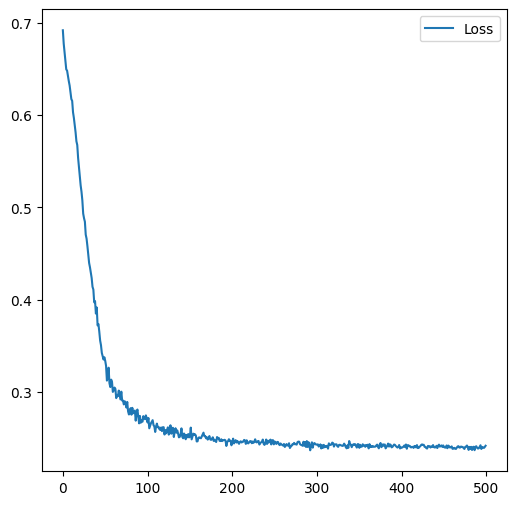

In [308]:
import matplotlib.pyplot as plt

model = lmodel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

accLog = []
acclog2 = []
epochs = 500
for epoch in range(0,epochs):
    val = model.forward(x=train_x)
    val = val.squeeze(1)
    
    loss = criterion(val,train_y)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()
    accLog.append(loss.item())
    with torch.no_grad():
        model_outputs = model.forward(x=val_x).squeeze(1)
        threshold = 0.5
        predicted_labels = (model_outputs >= threshold).float()  # Convert to 0 or 1

        # Step 2: Compare predictions with true labels
        correct_predictions = (predicted_labels == val_y).float()

        # Step 3: Calculate accuracy
        accuracy = correct_predictions.sum() / len(val_y)
        
        model_outputs = model.forward(x=train_x).squeeze(1)
        threshold = 0.5
        predicted_labels = (model_outputs >= threshold).float()  # Convert to 0 or 1

        # Step 2: Compare predictions with true labels
        correct_predictions = (predicted_labels == train_y).float()

        # Step 3: Calculate accuracy
        accuracy2 = correct_predictions.sum() / len(train_y)
        
    print(f"epoch number: {epoch}, loss: {loss.item()}, accuracy on val: {accuracy}, training acc: {accuracy2}")if epoch%50==0 else None
    
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(range(0,epochs),accLog,label="Loss")
plt.legend()
print("done")
plt.show()
    

In [344]:
#validation
columns = ["GENERAL APPEARANCE", "MANNER OF SPEAKING", "PHYSICAL CONDITION", 
           "MENTAL ALERTNESS", "SELF-CONFIDENCE", "ABILITY TO PRESENT IDEAS", 
           "COMMUNICATION SKILLS"]

value=[5,5,0,0,0,0,0]
# ans = ""
# for v in columns:
#     ans = int(input("your " + v + " (rate 1-5, integer only.)"))
#     while(ans <0 or ans >5):
#         ans = int(input("your " + v + " (rate 1-5, integer only.)"))
        
#     value.append(ans)

value = np.array(value)
value = value.reshape(1,7)
print(value)

value = scaler.transform(value)
inTensor=torch.tensor(value,dtype=torch.float32)

model = lmodel()

with torch.no_grad():
    pred = model.forward(inTensor)

print(f"chances of getting employed: {round(float(pred)*100,2)}%")


[[5 5 0 0 0 0 0]]
chances of getting employed: 50.47%
